# Izračun točk

In [49]:
import pandas as pd
import re

In [50]:
benchmarks = pd.read_csv("benchmarks.csv", names=["name", "sudoku", "result", "time"])

In [51]:
def kind(sudoku):
    match = re.search("(?P<kind>\w+)-\d+\.sdk", sudoku)
    if match:
        return match.group("kind")


benchmarks["kind"] = benchmarks.sudoku.apply(kind)

In [52]:
time_range = (
    benchmarks[benchmarks.result == "CORRECT"]
    .groupby("sudoku")
    .aggregate({"time": [("fastest", "min"), ("slowest", "max")]})
)
time_range.columns = time_range.columns.get_level_values(1)
benchmarks = pd.merge(benchmarks, time_range, on="sudoku", how="left")

In [53]:
incorrect = benchmarks.result != "CORRECT"
benchmarks.loc[incorrect, "time"] = benchmarks[incorrect].slowest * 2

benchmarks["relative_time"] = benchmarks.time / benchmarks.fastest

In [54]:
benchmarks

,name,sudoku,result,time,kind,fastest,slowest,relative_time
0,student-1,kletke-1.sdk,ERROR,NaN,kletke,NaN,NaN,NaN
1,student-1,kletke-10.sdk,ERROR,0.039622,kletke,0.003459,0.019811,11.454756
2,student-1,kletke-100.sdk,ERROR,0.002816,kletke,0.001408,0.001408,2.000000
3,student-1,kletke-11.sdk,ERROR,0.007602,kletke,0.003801,0.003801,2.000000
4,student-1,kletke-12.sdk,ERROR,NaN,kletke,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9862,student-9,termometri-95.sdk,WRONG,0.434490,termometri,0.002630,0.217245,165.205323
9863,student-9,termometri-96.sdk,TIMEOUT,0.003302,termometri,0.001651,0.001651,2.000000
9864,student-9,termometri-97.sdk,WRONG,0.007382,termometri,0.003691,0.003691,2.000000
9865,student-9,termometri-98.sdk,WRONG,0.005312,termometri,0.002656,0.002656,2.000000


## Točke za pravilnost

- 5 točk - 100% pravilno rešenih običajnih sudokujev
- 4 točke - ≥50% pravilno rešenih običajnih sudokujev
- 3 točke - >0% pravilno rešenih običajnih sudokujev
- 0-2 točki - odvisno od pravilnosti pomožnih funkcij - se določi ročno

In [55]:
number_of_correct = (
    benchmarks[(benchmarks.kind == "obicajni") & (benchmarks.result == "CORRECT")]
    .groupby("name")
    .size()
)

<AxesSubplot:xlabel='name'>

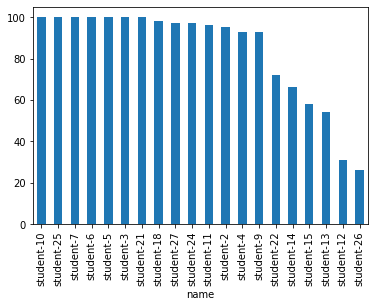

In [56]:
number_of_correct.sort_values(ascending=False).plot.bar()

In [57]:
total = len(set(benchmarks[benchmarks.kind == "obicajni"].sudoku))


def tocke_za_pravilnost(correct):
    if correct == total:
        return 5
    elif correct / total >= 0.5:
        return 4
    else:
        # če se vrednost pojavi, je moral biti vsaj en pravilen
        return 3

In [58]:
number_of_correct.apply(tocke_za_pravilnost)

name
student-10    5
student-11    4
student-12    3
student-13    4
student-14    4
student-15    4
student-18    4
student-2     4
student-21    5
student-22    4
student-24    4
student-25    5
student-26    3
student-27    4
student-3     5
student-4     4
student-5     5
student-6     5
student-7     5
student-9     4
dtype: int64

## Točke za hitrost

In [59]:
speed_benchmarks = benchmarks[
    (benchmarks.kind == "obicajni") & ~pd.isna(benchmarks.time)
]

<AxesSubplot:title={'center':'relative_time'}, xlabel='name'>

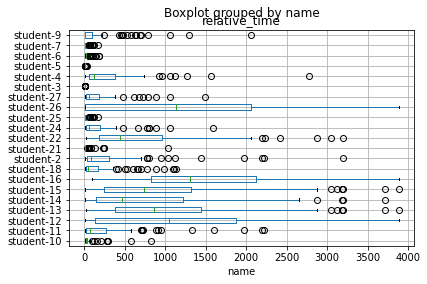

In [60]:
speed_benchmarks.boxplot("relative_time", by="name", vert=False)

name
student-10      47.365067
student-11     252.015021
student-12    1194.094429
student-13    1055.508032
student-14     801.386615
student-15     971.959312
student-16    1490.627048
student-18     163.702420
student-2      288.958100
student-21      32.879630
student-22     692.851793
student-24     156.364094
student-25      20.136035
student-26    1250.673455
student-27     149.873673
student-3        1.052391
student-4      287.697223
student-5        5.736805
student-6       28.242018
student-7       20.332330
student-9      132.955923
Name: relative_time, dtype: float64

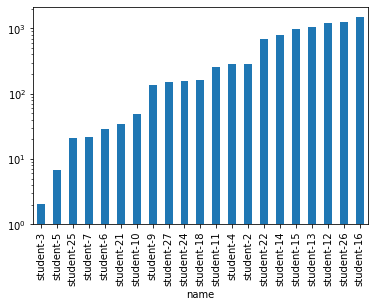

In [61]:
speed = speed_benchmarks.groupby("name").mean().relative_time
speed.sort_values().plot.bar(log=True)
speed

## Točke za razširitve



In [62]:
extension_benchmarks = benchmarks[
    (benchmarks.result != "ERROR") & (benchmarks.kind != "obicajni")
]

In [63]:
extension_benchmarks.groupby(["name", "kind", "result"]).size().unstack()

result                  CORRECT  TIMEOUT  WRONG
name       kind                                
student-17 kletke           NaN      1.0    1.0
student-19 kletke           1.0      1.0    NaN
student-20 kletke           NaN     96.0    1.0
student-23 kletke           NaN     16.0    NaN
student-3  kletke          88.0      9.0    NaN
           kombinirani     53.0      NaN    NaN
           puscice         98.0      2.0    NaN
           termometri     100.0      NaN    NaN
student-5  kletke           NaN      NaN   97.0
           kombinirani      NaN     24.0   29.0
           puscice         26.0     74.0    NaN
           termometri      30.0     70.0    NaN
student-6  termometri      12.0     88.0    NaN
student-9  kletke           NaN     12.0   85.0
           kombinirani      NaN      9.0   44.0
           puscice          NaN      7.0   93.0
           termometri       NaN      9.0   91.0

In [64]:
extension_benchmarks.groupby(["name", "kind"]).mean().relative_time

name        kind       
student-17  kletke          11.454756
student-19  kletke           5.727378
student-20  kletke           2.107440
student-23  kletke           2.675340
student-3   kletke           1.000000
            kombinirani      1.000000
            puscice          1.000000
            termometri       1.000000
student-5   kletke           2.107440
            kombinirani      2.000000
            puscice         25.442180
            termometri      71.664877
student-6   termometri     127.804518
student-9   kletke           2.107440
            kombinirani      2.000000
            puscice         49.414973
            termometri     162.318275
Name: relative_time, dtype: float64